

# Bitcoin Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1) 
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from one of the largest Bit‐
coin exchanges in terms of average daily volume traded—Bitstamp (https://
www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier 
from tensorflow.keras.optimizers import SGD



<a id='1.2'></a>
## 2.2. Loading the Data

#### <font color='red'>Note : Due to limit in the github for the data size, a sample of the data has been loaded in the jupyter notebook repository of this book. However, all the subsequent results in this jupyter notebook is with actual data (~150MB) under https://www.kaggle.com/mlfinancebook/bitstamp-bicoin-minutes-data. You should load the full data in case you want to reproduce the results. </font> 

In [3]:
# load dataset
dataset = pd.read_csv('/kaggle/input/btc-5m/btc_5m.csv')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [4]:
# shape
dataset

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
1,2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2,2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
3,2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
4,2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135
...,...,...,...,...,...,...
427809,2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080
427810,2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970
427811,2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230
427812,2022-01-31 05:25:00,37928.04,37945.25,37870.00,37881.76,57.851440


<Axes: >

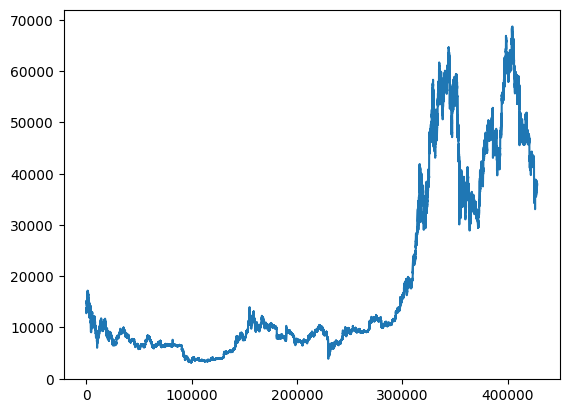

In [303]:
dataset['close'].plot()

In [304]:
# for col in dataset.columns:
#     print(f"Column name: {col}, Data type: {dataset[col].dtype}")

In [305]:
# dataset['datetime'] = pd.to_datetime(dataset['datetime'])
# dataset

In [306]:
# for col in dataset.columns:
#     print(f"Column name: {col}, Data type: {dataset[col].dtype}")
# dataset['datetime'] = dataset['datetime'].astype(np.int64) //10**9   # Divide by 1 billion to convert nanoseconds to seconds
# for col in dataset.columns:
#     print(f"Column name: {col}, Data type: {dataset[col].dtype}")
# dataset

In [307]:
# # peek at data
# set_option('display.width', 100)
# dataset.tail(5)

In [308]:
# # describe data
# # set_option('precision', 3)
# dataset.describe()

<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [309]:
# #Checking for any null values and removing the null values'''
# print('Null Values =',dataset.isnull().values.any())

Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

In [310]:
# dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [311]:
dataset=dataset.drop(columns=['datetime'])


<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [312]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['close'].rolling(window=3456, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['close'].rolling(window=12960, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [313]:
dataset

,open,high,low,close,volume,short_mavg,long_mavg,signal
0,13715.65,13715.65,13576.28,13600.00,33.617798,13600.000000,13600.000000,0.0
1,13600.00,13600.00,13501.01,13554.58,40.528679,13577.290000,13577.290000,0.0
2,13554.58,13569.97,13400.01,13556.15,49.469536,13570.243333,13570.243333,0.0
3,13533.75,13547.73,13402.00,13430.52,32.725614,13535.312500,13535.312500,0.0
4,13440.01,13459.99,13410.44,13439.94,26.614135,13516.238000,13516.238000,0.0
...,...,...,...,...,...,...,...,...
427809,37950.55,37979.31,37875.58,37959.87,119.164080,37659.176021,43678.537352,0.0
427810,37959.87,37959.88,37876.94,37896.41,73.051970,37657.876887,43677.782561,0.0
427811,37896.41,37948.79,37870.00,37928.03,41.395230,37656.588764,43677.030864,0.0
427812,37928.04,37945.25,37870.00,37881.76,57.851440,37655.295258,43676.278502,0.0


In [314]:
(dataset['signal']==0.0).sum()

212583

<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [315]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
# dataset['EMA12'] = EMA(dataset, 3456)
# dataset['EMA26'] = EMA(dataset, 7488)
# dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
# dataset['ROC10'] = ROC(dataset['close'], 3456)
# dataset['ROC30'] = ROC(dataset['close'], 7488)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
# dataset['MOM10'] = MOM(dataset['close'], 3456)
# dataset['MOM30'] = MOM(dataset['close'], 7488)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['close'], 3456)
# dataset['RSI30'] = RSI(dataset['close'], 7488)
# dataset['RSI200'] = RSI(dataset['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

# dataset['%K10'] = STOK(dataset['close'], dataset['low'], dataset['high'], 3456)
# dataset['%D10'] = STOD(dataset['close'], dataset['low'], dataset['high'], 3456)
# dataset['%K30'] = STOK(dataset['close'], dataset['low'], dataset['high'], 7488)
# dataset['%D30'] = STOD(dataset['close'], dataset['low'], dataset['high'], 7488)
# dataset['%K200'] = STOK(dataset['close'], dataset['low'], dataset['high'], 200)
# dataset['%D200'] = STOD(dataset['close'], dataset['low'], dataset['high'], 200)

In [316]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
# dataset['MA21'] = MA(dataset, 3456)
# dataset['MA63'] = MA(dataset, 7488)
# dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,open,high,low,close,volume,short_mavg,long_mavg,signal,RSI10
427809,37950.55,37979.31,37875.58,37959.87,119.16408,37659.176021,43678.537352,0.0,49.512629
427810,37959.87,37959.88,37876.94,37896.41,73.05197,37657.876887,43677.782561,0.0,49.498064
427811,37896.41,37948.79,37870.00,37928.03,41.39523,37656.588764,43677.030864,0.0,49.505467
427812,37928.04,37945.25,37870.00,37881.76,57.85144,37655.295258,43676.278502,0.0,49.494847
427813,37881.75,37951.07,37869.98,37872.66,98.33909,37654.016826,43675.518949,0.0,49.492758


In [317]:
# dataset.tail()

In [318]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['high','low','open'], axis=1)

In [319]:
# dataset = dataset.dropna(axis=0)

In [320]:
dataset=dataset.drop(['volume'], axis=1)
dataset.tail()

,close,short_mavg,long_mavg,signal,RSI10
427809,37959.87,37659.176021,43678.537352,0.0,49.512629
427810,37896.41,37657.876887,43677.782561,0.0,49.498064
427811,37928.03,37656.588764,43677.030864,0.0,49.505467
427812,37881.76,37655.295258,43676.278502,0.0,49.494847
427813,37872.66,37654.016826,43675.518949,0.0,49.492758


<a id='3.4'></a>
## 4.4. Data Visualization

In [321]:
# dataset[['Weighted_Price']].plot(grid=True)
# plt.show()

In [322]:
# # histograms
# dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
# plt.show()

In [323]:
# fig = plt.figure()
# plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
# plt.show()

The predicted variable is upward 52.87% out of total data-size, meaning that number
of the buy signals were more than the number of sell signals. 

In [324]:
# # correlation
# correlation = dataset.corr()
# plt.figure(figsize=(15,15))
# plt.title('Correlation Matrix')
# sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [325]:
# split out validation dataset for the end
# subset_dataset= dataset.iloc[-100000:]
subset_dataset=dataset
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
# seed = 1
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size,random_state=42)
X_train=X[0:int(0.8*len(X))]
Y_train=Y[0:int(0.8*len(Y))]
X_validation=X[int(0.8*len(X)):]
Y_validation=Y[int(0.8*len(Y)):]

In [326]:
X_validation

,close,short_mavg,long_mavg,RSI10
342251,57105.21,57819.841030,54313.860473,50.092918
342252,57169.17,57820.477364,54313.929468,50.103768
342253,57245.43,57821.161968,54314.011677,50.116702
342254,57105.56,57821.828854,54314.097804,50.092879
342255,57033.47,57822.487700,54314.187729,50.080606
...,...,...,...,...
427809,37959.87,37659.176021,43678.537352,49.512629
427810,37896.41,37657.876887,43677.782561,49.498064
427811,37928.03,37656.588764,43677.030864,49.505467
427812,37881.76,37655.295258,43676.278502,49.494847


In [327]:
X_train.head(4000)

,close,short_mavg,long_mavg,RSI10
0,13600.00,13600.000000,13600.000000,NaN
1,13554.58,13577.290000,13577.290000,NaN
2,13556.15,13570.243333,13570.243333,NaN
3,13430.52,13535.312500,13535.312500,NaN
4,13439.94,13516.238000,13516.238000,NaN
...,...,...,...,...
3995,13452.00,14804.237867,14629.262518,49.947904
3996,13492.00,14803.843481,14628.977988,49.959509
3997,13554.99,14803.449957,14628.709357,49.977780
3998,13470.05,14803.030414,14628.419620,49.953179


<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [328]:
# # test options for classification
# num_folds = 10
# seed = 7
# scoring = 'accuracy'
# #scoring = 'precision'
# #scoring = 'recall'def ROC(df, n):  def ROC(df, n):  
#     M = df.diff(n - 1)  
#     N = df.shift(n - 1)  
#     ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
#     return ROC
# dataset['ROC10'] = ROC(dataset['close'], 10)
# dataset['ROC30'] = ROC(dataset['close'], 30)
#     M = df.diff(n - 1)  
#     N = df.shift(n - 1)  
#     ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
#     return ROC
# dataset['ROC10'] = ROC(dataset['close'], 10)
# dataset['ROC30'] = ROC(dataset['close'], 30)
# #scoring ='neg_log_loss'
# #scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [329]:
# # spot check the algorithms
# models = []
# models.append(('LR', LogisticRegression(n_jobs=-1)))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# #Ensable Models 
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [330]:
# results = []
# names = []
# for name, model in models:
#     kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
#     cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [331]:
# # compare algorithms
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# fig.set_size_inches(15,8)
# plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [332]:
# # Grid Search: Random Forest Classifier
# '''
# n_estimators : int (default=100)
#     The number of boosting stages to perform. 
#     Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
# max_depth : integer, optional (default=3)
#     maximum depth of the individual regression estimators. 
#     The maximum depth limits the number of nodes in the tree. 
#     Tune this parameter for best performance; the best value depends on the interaction of the input variables    
# criterion : string, optional (default=”gini”)
#     The function to measure the quality of a split. 
#     Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
# '''   
# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)
# n_estimators = [20,80]
# max_depth= [5,10]
# criterion = ["gini","entropy"]
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
# model = RandomForestClassifier(n_jobs=-1)
# kfold = KFold(n_splits=10, random_state=7, shuffle=True)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
# grid_result = grid.fit(rescaledX, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [333]:
import xgboost as xgb
# prepare model
# model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
params = {
    'objective': 'binary:logistic',  # for binary classification problems
    'eval_metric': 'logloss',        # log likelihood loss for binary classification
    'max_depth': 3,                  # depth of the trees
    'eta': 0.1,                      # learning rate
    'subsample': 0.8,                # fraction of samples used for training
    'colsample_bytree': 1,         # fraction of features used for training
    'seed': 42                       # random seed for reproducibility
}

# Convert data to DMatrix format (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=Y_train)
# dtest = xgb.DMatrix(X_validation, label=Y_validation)
dtest = xgb.DMatrix(X, label=Y)


# Train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred_prob = model.predict(dtest)
# predictions=y_pred_prob
predictions = [1 if pred > 0.5 else 0 for pred in y_pred_prob]

# Evaluate the model
# accuracy = accuracy_score(Y_validation, predictions)
# print(f'Accuracy: {accuracy * 100:.2f}%')
# model.fit(X_train[8000:], Y_train[8000:])

In [334]:
# # estimate accuracy on validation set
# predictions = model.predict(X_validation)
# print(accuracy_score(Y_validation, predictions))
# print(confusion_matrix(Y_validation, predictions))
# print(classification_report(Y_validation, predictions))

In [335]:
# df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

In [336]:
# Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
# Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
# plt.xlabel('Variable Importance')

<a id='7'></a>
## 8. Backtesting Results

In [337]:
# #Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# #of business the previous day
# backtestdata = pd.DataFrame(index=X_validation.index)
# #backtestdata = pd.DataFrame()
# backtestdata['signal_pred'] = predictions
# backtestdata['signal_actual'] = Y_validation
# backtestdata['Market Returns'] = X_validation['close'].pct_change()
# backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
# backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
# backtestdata=backtestdata.reset_index()
# backtestdata.head()
# backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
# backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

ValueError: Length of values (427814) does not match length of index (85563)

__Conclusion__:

We showed that framing the problem is the first priority and we address it by engi‐
neering the features and transforming the labels according to the investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of
intuitive features related to the trend and momentum of the price movement and
increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy
or auc are appropriate, but in case the strategy is focusing to be more accurate while
going long, the metric recall which focuses on less false positive can be preferred as
compared to accuracy.

Finally, we demonstrated the backtesting framework which allows us to simulate a
trading strategy using historical data to generate results and analyze risk and profita‐
bility before risking any actual capital.


In [339]:
X['predictions'] = predictions  # Directly assign the array as a new column
X


,close,short_mavg,long_mavg,RSI10,predictions
0,13600.00,13600.000000,13600.000000,NaN,0
1,13554.58,13577.290000,13577.290000,NaN,0
2,13556.15,13570.243333,13570.243333,NaN,0
3,13430.52,13535.312500,13535.312500,NaN,0
4,13439.94,13516.238000,13516.238000,NaN,0
...,...,...,...,...,...
427809,37959.87,37659.176021,43678.537352,49.512629,1
427810,37896.41,37657.876887,43677.782561,49.498064,1
427811,37928.03,37656.588764,43677.030864,49.505467,1
427812,37881.76,37655.295258,43676.278502,49.494847,1


In [340]:
capital=100000
invested=0
status='sell'
net_worth=[]
for index, row in X.iterrows():
    close_value = row['close']
    prediction_value = row['predictions']
    if prediction_value==1.0 and status!='buy':
        invested=capital/close_value
        capital=0
        status='buy'
        print(f'bought at {close_value},{index}')
    elif prediction_value==0.0 and status!='sell':
        capital=int(invested*close_value)
        invested=0
        status='sell'
        print(f'sold at {close_value},{index}')
        print('net_worth',capital)
    net_worth.append(capital+invested*close_value)
# print(capital)

bought at 14077.0,3456
sold at 9785.85,4560
net_worth 69516
bought at 10159.59,4567
sold at 9965.0,4568
net_worth 68184
bought at 10510.0,4569
sold at 9960.01,4623
net_worth 64615
bought at 10047.4,4626
sold at 10000.01,4627
net_worth 64310
bought at 10089.0,4629
sold at 9930.02,4705
net_worth 63296
bought at 10116.89,4707
sold at 9830.03,4708
net_worth 61501
bought at 10070.0,4717
sold at 10013.88,4720
net_worth 61158
bought at 10068.72,4721
sold at 10033.0,4723
net_worth 60941
bought at 10093.66,4732
sold at 10030.01,4739
net_worth 60556
bought at 10130.03,4742
sold at 10015.27,4746
net_worth 59869
bought at 10108.1,4784
sold at 10019.99,4786
net_worth 59347
bought at 10287.97,4787
sold at 10049.82,4789
net_worth 57973
bought at 12998.95,5672
sold at 12969.82,5673
net_worth 57843
bought at 12987.31,5674
sold at 12955.01,5676
net_worth 57699
bought at 10583.03,16178
sold at 8194.97,21203
net_worth 44679
bought at 8916.71,31323
sold at 8916.15,31338
net_worth 44676
bought at 8795.0,315

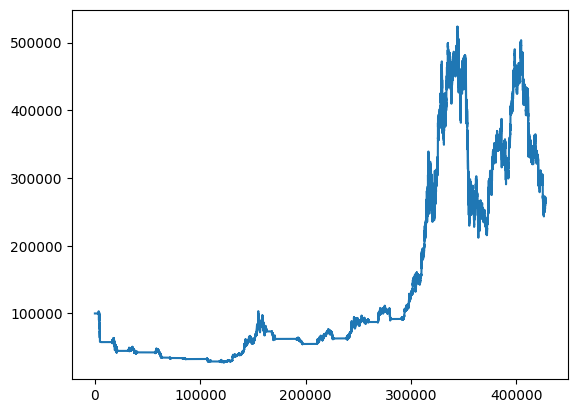

In [341]:
plt.plot(net_worth)